# Recurrent Neural Networks (RNN)

&copy; 李浩东 haodongli@zju.edu.cn

- Sequence Models
- Text Preprocessing
- Language Models and the Dataset
- Recurrent Neural Networks


$$
x_{t} \sim P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

- Music, speech, text, and videos are all sequential in nature. If we were to permute them they would make little sense. The headline dog bites man is much less surprising than man bites dog, even though the words are identical.

- In order to achieve this, we could use a regression model.

$$
x_{t} \sim P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right) \sim P\left(x_{t} \mid x_{t-1},  x_{t-2},\ldots, x_{t-\tau}\right)
$$

- Such models will be called autoregressive models, as they quite literally perform regression on themselves.

- The second strategy, shown in the figure below, is to keep some summary $h_t$ of the past observations, and at the same time update $h_t$ in addition to the prediction $\hat{x}_{t}$. This leads to models that estimate ${x}_{t}$ with $\hat{x}_{t}=P\left(x_{t} \mid h_{t}\right)$ and moreover updates of the form $h_{t}=g\left(h_{t-1}, x_{t-1}\right)$. Since $h_t$ is never observed, these models are also called latent autoregressive models.

![sequence-model.svg](./images/8/sequence-model.svg)


- Both cases raise the obvious question of how to generate training data. One typically uses historical observations to predict the next observation given the ones up to right now. Obviously we do not expect time to stand still. However, a common assumption is that while the specific values of $x_t$ might change, at least the dynamics of the sequence itself will not. This is reasonable, since novel dynamics are just that, novel and thus not predictable using data that we have so far. Statisticians call dynamics that do not change stationary. Regardless of what we do, we will thus get an estimate of the entire sequence via:

$$
P\left(x_{1}, \ldots, x_{T}\right)=\prod_{t=1}^{T} P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

- Note that the above considerations still hold if we deal with discrete objects, such as words, rather than continuous numbers. The only difference is that in such a situation we need to use a classifier rather than a regression model to estimate it.

# Markov Models

- Recall the approximation that in an autoregressive model we use only $x_{t-1}, \ldots, x_{t-\tau}$ instead of $x_{t-1}, \ldots, x_{t-1}$ to estimate $x_t$. Whenever this approximation is accurate we say that the sequence satisfies a Markov condition. In particular, if $\tau=1$, we have a first-order Markov model and $P(x)$ is given by:

$$
P\left(x_{1}, \ldots, x_{T}\right)=\prod_{t=1}^{T} P\left(x_{t} \mid x_{t-1}\right) \text { where } P\left(x_{1} \mid x_{0}\right)=P\left(x_{1}\right)
$$


- Such models are particularly nice whenever $x_t$ assumes only a discrete value, since in this case dynamic programming can be used to compute values along the chain exactly. For instance, we can compute $P\left(x_{t+1} \mid x_{t-1}\right)$ efficiently:
 
$$
\begin{aligned}
P\left(x_{t+1} \mid x_{t-1}\right) &=\frac{\sum_{x t} P\left(x_{t+1}, x_{t}, x_{t-1}\right)}{P\left(x_{t-1}\right)} \\
&=\frac{\sum_{x t} P\left(x_{t+1} \mid x_{t}, x_{t-1}\right) P\left(x_{t}, x_{t-1}\right)}{P\left(x_{t-1}\right)} \\
&=\sum_{x_{t}} P\left(x_{t+1} \mid x_{t}\right) P\left(x_{t} \mid x_{t-1}\right)
\end{aligned}
$$


- In fact, if we have a Markov model, we can obtain a reverse conditional probability distribution, too. In many cases, however, there exists a natural direction for the data, namely going forward in time. It is clear that future events cannot influence the past. Hence, if we change $x_t$, we may be able to influence what happens for $x_{t+1}$ going forward but not the converse. That is, if we change $x_t$, the distribution over past events will not change. Consequently, it ought to be easier to explain $P\left(x_{t+1} \mid x_{t}\right) $
 rather than $P\left(x_{t} \mid x_{t+1}\right) $.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.optim as optim
import requests
import collections
from torch.nn import functional as F
import re
# import time
import math
import random
from torch.utils import data
import hashlib
import os
print(torch.__version__)

1.11.0


(1.0, 1000.0)

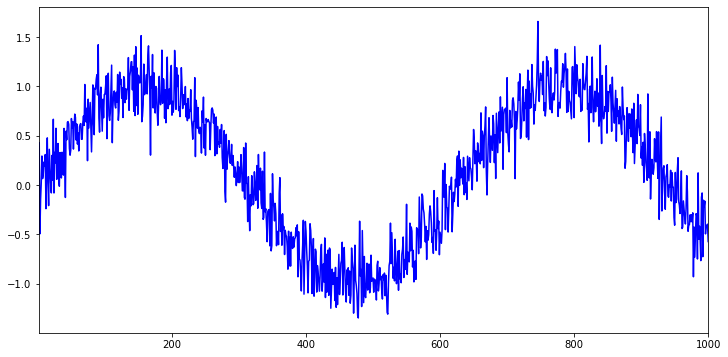

In [2]:
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(12, 6))
plt.plot(time, x, '-b')
plt.xlim(1, 1000)

In [3]:
def generate_date(tau):
    features = torch.zeros((T - tau, tau))
    for i in range(tau):
        features[:, i] = x[i: T - tau + i]
    labels = x[tau:].reshape((-1, 1))
    num_workers = 0
    batch_size, n_train = 20, 600
    train_loader = DataLoader(dataset=data.TensorDataset(features[:n_train], labels[:n_train]), 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers)
    train_iter = iter(train_loader)
    test_loader = DataLoader(dataset=data.TensorDataset(features[n_train:], labels[n_train:]), 
                              batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = iter(test_loader)
    print(len(train_loader), len(test_loader))
    print(len(train_iter), len(test_iter))
    return train_loader, test_loader, features

train_loader, test_loader, features = generate_date(tau=4)

30 20
30 20


In [4]:
datas, targets = next(iter(train_loader))
print(datas)
print(targets)

tensor([[ 0.9129,  1.4217,  0.6786,  0.5357],
        [ 0.3694,  0.3018,  0.3527,  0.6734],
        [ 0.1396, -0.3484, -0.3318,  0.3335],
        [ 1.2910,  0.7567,  1.1020,  1.1510],
        [-0.6803, -0.6971, -0.7796, -0.3869],
        [-0.6435, -0.5256, -0.6300, -0.5475],
        [ 0.2834,  0.3532,  0.4497,  0.2817],
        [ 0.9646,  1.1996,  0.7468,  1.3165],
        [-1.0178, -1.0986, -1.3208, -1.3482],
        [ 0.1829,  0.1130, -0.0066,  0.0979],
        [ 0.0174, -0.2091,  0.3615,  0.1878],
        [-0.8771, -1.0745, -1.1865, -0.8613],
        [-0.6647, -0.9520, -0.8991, -0.9913],
        [ 1.1012,  0.9812,  1.3224,  0.7805],
        [ 0.7449,  0.9660,  0.6778,  0.5861],
        [ 0.7645,  0.6381,  0.7783,  0.2462],
        [ 0.3315,  0.2322,  0.1001,  0.5734],
        [ 0.6303,  0.3578,  0.5908,  0.7649],
        [ 0.9270,  0.9531,  0.8100,  0.7802],
        [-1.0004, -0.8097, -0.6716, -1.0671]])
tensor([[ 0.9197],
        [ 0.5742],
        [-0.2718],
        [ 1.2469],
   

In [5]:
def simple_mlp():
    net = nn.Sequential(nn.Linear(4, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1))
    return net

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.model = simple_mlp()
    def forward(self, x):
        x = self.model(x)
        return x

In [6]:
def train_model(model, name, epoch_num=500, device='cuda', learning_rate=0.01, train_loader=train_loader, test_loader=test_loader):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    if device == 'cuda':
        print("Use CUDA for training.")
        model = torch.nn.DataParallel(model) # make parallel
        cudnn.benchmark = True
    
    model.to(device)
    # specify loss function
    criterion = nn.MSELoss(reduction='none')
    # specify optimizer
    optimizer = optim.Adam(model.parameters(), learning_rate)
    train_losslist = []
    valid_losslist = []

    for epoch in range(1, epoch_num+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.sum().backward()
            optimizer.step()
            train_loss += loss.sum().item()*data.size(0)

        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.sum().item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_losslist.append(train_loss)
        valid_losslist.append(valid_loss)
        print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t valid_loss ->", valid_loss)
    
    os.mkdir("./result/") if os.path.exists("./result/") == False else print("./result/ exists.")
    torch.save(model.state_dict(), './result/' + name + '.pt')
    return train_losslist, valid_losslist, model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_losslist, valid_losslist, model = train_model(SimpleMLP(), "reg_sin_simplemlp", 
                                                    10, device, learning_rate=0.05)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.590431062380473 			 valid_loss -> 1.2389005639336326
Epoch -> 2 	 train_loss -> 1.1704057296117147 			 valid_loss -> 1.7951183860952205
Epoch -> 3 	 train_loss -> 1.2141841918230056 			 valid_loss -> 1.2576977171079078
Epoch -> 4 	 train_loss -> 1.1336304724216462 			 valid_loss -> 1.1760255363252428
Epoch -> 5 	 train_loss -> 1.1412086109320323 			 valid_loss -> 1.1651216161371483
Epoch -> 6 	 train_loss -> 1.2022289117177327 			 valid_loss -> 1.1709889817719508
Epoch -> 7 	 train_loss -> 1.1765139768520991 			 valid_loss -> 1.1640310149000148
Epoch -> 8 	 train_loss -> 1.2275258978207906 			 valid_loss -> 1.397282317431286
Epoch -> 9 	 train_loss -> 1.3512031773726145 			 valid_loss -> 1.2245428495936923
Epoch -> 10 	 train_loss -> 1.1404260714848837 			 valid_loss -> 1.2579764302330787
./result/ exists.


In [8]:
def plot_losses(train_losslist, valid_losslist):
    plt.plot(train_losslist, '-bx')
    plt.plot(valid_losslist, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

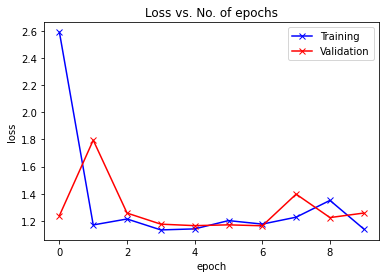

In [9]:
plot_losses(train_losslist, valid_losslist)

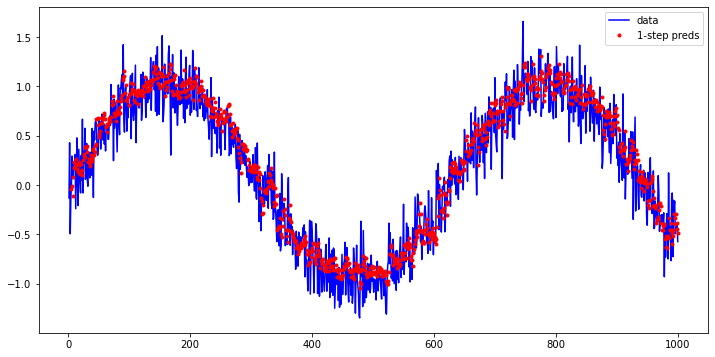

In [10]:
tau, n_train = 4, 600
onestep_preds = model(features)
plt.figure(figsize=(12, 6))
plt.plot(time, x.detach().numpy(), '-b')
plt.plot(time[tau:], onestep_preds.cpu().detach().numpy(), '.r')
plt.legend(['data', '1-step preds'])

- The one-step-ahead predictions look nice, just as we expected. Even beyond `604 (n_train + tau)` observations the predictions still look trustworthy. However, there is just one little problem to this: if we observe sequence data only until time step 604, we cannot hope to receive the inputs for all the future one-step-ahead predictions. Instead, we need to work our way forward one step at a time:

$$
\begin{split}\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots\end{split}
$$


In [11]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = model(multistep_preds[i - tau:i].reshape((1, -1)))

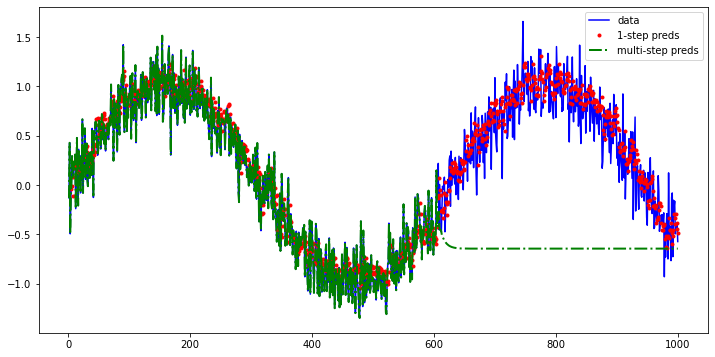

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(time, x.detach().numpy(), '-b')
plt.plot(time[tau:], onestep_preds.cpu().detach().numpy(), '.r')
plt.plot(time, multistep_preds.cpu().detach().numpy(), '-.g', linewidth=2)
plt.legend(['data', '1-step preds', 'multi-step preds'])
# plt.ylim(-4, 2)

- Let us take a closer look at the difficulties in -step-ahead predictions by computing predictions on the entire sequence for $k=1, 4, 16, 64$.

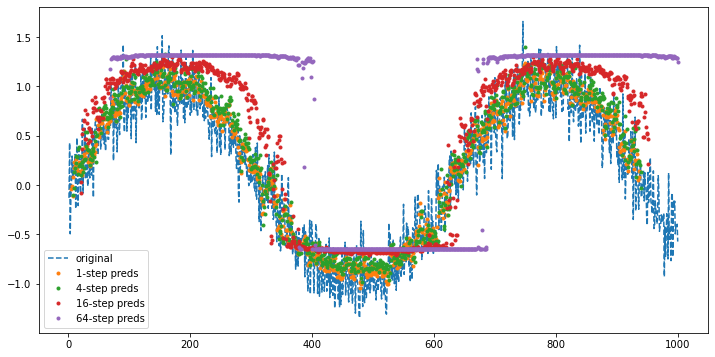

In [13]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = model(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
plt.figure(figsize=(12, 6))
plt.plot(time, x.detach().numpy(), '--')
for step in steps:
    plt.plot(time[tau + step - 1: T - max_steps + step], features[:, (tau + step - 1)].cpu().detach().numpy(), '.')
plt.legend(["original"] + [str(step) + '-step preds' for step in steps])

# Text Preprocessing

- Load text as strings into memory.
- Split strings into tokens (e.g., words and characters).
- Build a table of vocabulary to map the split tokens to numerical indices.
- Convert text into sequences of numerical indices so they can be manipulated by models easily.


In [2]:
def download(url, sha1_hash, cache_dir=os.path.join('.', 'data')):
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
txt_file = download('http://d2l-data.s3-accelerate.amazonaws.com/' + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print("text lines ->", len(lines))
print(lines[0])
print(lines[10])

text lines -> 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### Tokenization

- The following tokenize function takes a list (lines) as the input, where each element is a text sequence (e.g., a text line). Each text sequence is split into a list of tokens. A token is the basic unit in text. In the end, a list of token lists are returned, where each token is a string.

In [4]:
def tokenize(lines, token='char'):  #@save
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines, token='word')
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


### Vocabulary

- The string type of the token is inconvenient to be used by models, which take numerical inputs. Now let us build a dictionary, often called vocabulary as well, to map string tokens into numerical indices starting from 0. To do so, we first count the unique tokens in all the documents from the training set, namely a corpus, and then assign a numerical index to each unique token according to its frequency. Rarely appeared tokens are often removed to reduce the complexity. Any token that does not exist in the corpus or has been removed is mapped into a special unknown token "\<unk>". We optionally add a list of reserved tokens, such as "\<pad>" for padding, "\<bos>" to present the beginning for a sequence, and "\<eos>" for the end of a sequence.

In [5]:
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [6]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [7]:
def load_corpus_time_machine(max_tokens=-1, token='char'):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, token)
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine(token='char')
print(len(corpus), len(vocab))
corpus, vocab = load_corpus_time_machine(token='word')
print(len(corpus), len(vocab))

170580 28
32775 4580


# Language Models

- Assume that the tokens in a text sequence of length $T$ are in turn $x_{1}, x_{2}, \ldots, x_{T}$. Then, in the text sequence, $x_{t}(1 \leqslant t \leqslant T)$ can be considered as the observation or label at time step $t$. Given such a text sequence, the goal of a language model is to estimate the joint probability of the sequence:

$$
P\left(x_{1}, x_{2}, \ldots, x_{T}\right)
$$

- The obvious question is how we should model a document, or even a sequence of tokens. Suppose that we tokenize text data at the word level. Let us start by applying basic probability rules:

$$
P\left(x_{1}, x_{2}, \ldots, x_{T}\right)=\prod_{t=1}^{T} P\left(x_{t} \mid x_{1}, \ldots, x_{t-1}\right)
$$

$$
P(\text { deep, learning, is, fun })=P(\text { deep }) P(\text { learning } \mid \text { deep }) P(\text { is } \mid \text { deep, learning }) P(\text { fun } \mid \text { deep, learning, is })
$$


-  The probability of words can be calculated from the relative word frequency of a given word in the training dataset. For example, the estimate $\hat{P}(\text{deep})$ can be calculated as the probability of any sentence starting with the word “deep”. A slightly less accurate approach would be to count all occurrences of the word “deep” and divide it by the total number of words in the corpus.
 
$$
\hat{P}(\text { learning } \mid \text { deep })=\frac{n(\text { deep }, \text { learning })}{n(\text { deep })}
$$


- where $n(x)$ and $n(x, x') $ are the number of occurrences of singletons and consecutive word pairs, respectively.


- Unfortunately, estimating the probability of a word pair is somewhat more difficult, since the occurrences of “deep learning” are a lot less frequent. In particular, for some unusual word combinations it may be tricky to find enough occurrences to get accurate estimates.
-  Things take a turn for the worse for three-word combinations and beyond. There will be many plausible three-word combinations that we likely will not see in our dataset. Unless we provide some solution to assign such word combinations nonzero count, we will not be able to use them in a language model. If the dataset is small or if the words are very rare, we might not find even a single one of them.

- A common strategy is to perform some form of Laplace smoothing. The solution is to add a small constant to all counts. Denote by $n$ the total number of words in the training set and $m$ the number of unique words. This solution helps with singletons, e.g., via:

$$
\begin{aligned}
\hat{P}(x) &=\frac{n(x)+\epsilon_{1} / m}{n+\epsilon_{1}} \\
\hat{P}\left(x^{\prime} \mid x\right) &=\frac{n\left(x, x^{\prime}\right)+\epsilon_{2} \hat{P}\left(x^{\prime}\right)}{n(x)+\epsilon_{2}} \\
\hat{P}\left(x^{\prime \prime} \mid x, x^{\prime}\right) &=\frac{n\left(x, x^{\prime}, x^{\prime \prime}\right)+\epsilon_{3} \hat{P}\left(x^{\prime \prime}\right)}{n\left(x, x^{\prime}\right)+\epsilon_{3}}
\end{aligned}
$$

- Here $\epsilon_{1}$, $\epsilon_{2}$ and $\epsilon_{3}$ are hyperparameters.


- Unfortunately, models like this get unwieldy rather quickly for the following reasons. First, we need to store all counts. Second, this entirely ignores the meaning of the words. 
- For instance, “cat” and “feline” should occur in related contexts. It is quite difficult to adjust such models to additional contexts, whereas, deep learning based language models are well suited to take this into account. 
- Last, long word sequences are almost certain to be novel, hence a model that simply counts the frequency of previously seen word sequences is bound to perform poorly there.

# Markov Models

$$
\begin{aligned}
&P\left(x_{1}, x_{2}, x_{3}, x_{4}\right)=P\left(x_{1}\right) P\left(x_{2}\right) P\left(x_{3}\right) P\left(x_{4}\right) \\
&P\left(x_{1}, x_{2}, x_{3}, x_{4}\right)=P\left(x_{1}\right) P\left(x_{2} \mid x_{1}\right) P\left(x_{3} \mid x_{2}\right) P\left(x_{4} \mid x_{3}\right) \\
&P\left(x_{1}, x_{2}, x_{3}, x_{4}\right)=P\left(x_{1}\right) P\left(x_{2} \mid x_{1}\right) P\left(x_{3} \mid x_{1}, x_{2}\right) P\left(x_{4} \mid x_{2}, x_{3}\right)
\end{aligned}
$$

- The probability formulae that involve one, two, and three variables are typically referred to as unigram, bigram, and trigram models, respectively.


In [8]:
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

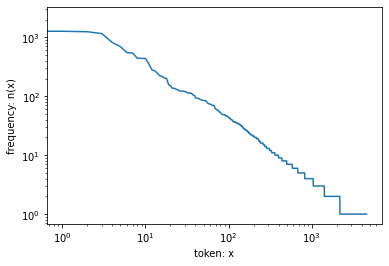

In [9]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(freqs)
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')

- We are on to something quite fundamental here: the word frequency decays rapidly in a well-defined way. After dealing with the first few words as exceptions, all the remaining words roughly follow a straight line on a log-log plot. This means that words satisfy Zipf’s law, which states that the frequency $n_i$ of the $i^{\text{th}}$ most frequent word is:

$$
\begin{gathered}
n_{i} \propto \frac{1}{i \alpha} \\\\\Rightarrow\quad
\log n_{i}=-\alpha \log i+c,
\end{gathered}
$$

- Where $\alpha$ is the exponent that characterizes the distribution and $c$ is a constant.
- But what about the other word combinations, such as bigrams, trigrams, and beyond?


In [10]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[((4, 1), 309),
 ((8, 1), 169),
 ((2, 12), 130),
 ((2, 7), 112),
 ((3, 1), 109),
 ((1, 19), 102),
 ((11, 7), 99),
 ((6, 1), 85),
 ((14, 2), 78),
 ((4, 5), 73)]

In [11]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[((1, 19, 71), 59),
 ((1, 19, 50), 30),
 ((1, 177, 65), 24),
 ((11, 63, 6), 16),
 ((11, 7, 5), 15),
 ((103, 3, 26), 15),
 ((63, 6, 13), 14),
 ((2, 107, 33), 14),
 ((2, 47, 1), 13),
 ((2, 110, 6), 13)]

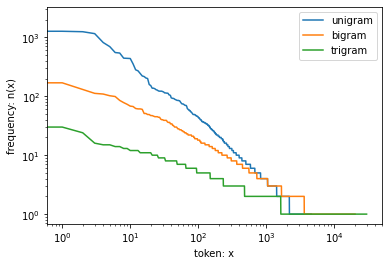

In [12]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

plt.plot(freqs)
plt.plot(bigram_freqs)
plt.plot(trigram_freqs)
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.legend(['unigram', 'bigram', 'trigram'])

- This figure is quite exciting for a number of reasons. First, beyond unigram words, sequences of words also appear to be following Zipf’s law, albeit with a smaller exponent $\alpha$, depending on the sequence length.
- Second, the number of distinct $n$-grams is not that large. This gives us hope that there is quite a lot of structure in language. Third, many $n$-grams occur very rarely, which makes Laplace smoothing rather unsuitable for language modeling. Instead, we will use deep learning based models.

# Long Sequence Data

- When sequences get too long to be processed by models all at once, we may wish to split such sequences for reading. Now let us describe general strategies. Before introducing the model, let us assume that we will use a neural network to train a language model, where the network processes a minibatch of sequences with predefined length, say $n$ time steps, at a time. Now the question is how to read minibatches of features and labels at random.
- The figure below shows all the different ways to obtain subsequences from an original text sequence, where  and a token at each time step corresponds to a character.

![timemachine-5gram.svg](./images/8/timemachine-5gram.svg)


# Random Sampling

- However, if we pick just one offset, there is limited coverage of all the possible subsequences for training our network. Therefore, we can start with a random offset to partition a sequence to get both coverage and randomness. 
- In random sampling, each example is a subsequence arbitrarily captured on the original long sequence. The subsequences from two adjacent random minibatches during iteration are not necessarily adjacent on the original sequence. For language modeling, the target is to predict the next token based on what tokens we have seen so far, hence the labels are the original sequence, shifted by one token.


In [13]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [14]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5]])
X:  tensor([[20, 21, 22, 23, 24],
        [15, 16, 17, 18, 19]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [16, 17, 18, 19, 20]])
X:  tensor([[25, 26, 27, 28, 29],
        [10, 11, 12, 13, 14]]) 
Y: tensor([[26, 27, 28, 29, 30],
        [11, 12, 13, 14, 15]])


In [15]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [16]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [17]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [18]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# Recurrent Neural Networks

- We have introduced $n$-gram models, where the conditional probability of word $x_t$ at time step $t$ only depends on the $n-1$ previous words. If we want to incorporate the possible effect of words earlier than time step $t-(n-1)$ on $x_t$, we need to increase $n$. However, the number of model parameters would also increase exponentially with it, as we need to store $|V|^n$ numbers for a vocabulary set $V$. Hence, rather than modeling $P\left(x_{t} \mid x_{t-1}, \ldots, x_{t-n+1}\right)$ it is preferable to use a latent variable model:

$$
P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right) \approx P\left(x_{t} \mid h_{t-1}\right)
$$


- where $h_{t-1}$ is a hidden state (also known as a hidden variable) that stores the sequence information up to time step $t-1$. In general, the hidden state at any time step $t$ could be computed based on both the current input $x_t$ and the previous hidden state $h_{t-1}$:

$$
h_{t}=f\left(x_{t}, h_{t-1}\right)
$$


- For a sufficiently powerful function $f$, the latent variable model is not an approximation. After all, $h_t$ may simply store all the data it has observed so far. However, it could potentially make both computation and storage expensive.
- Recall that we have discussed hidden layers with hidden units. It is noteworthy that hidden layers and hidden states refer to two very different concepts. Hidden layers are, as explained, layers that are hidden from view on the path from input to output. Hidden states are technically speaking inputs to whatever we do at a given step, and they can only be computed by looking at data at previous time steps.
- Recurrent neural networks (RNNs) are neural networks with hidden states.

- Let us take a look at an MLP with a single hidden layer. Let the hidden layer’s activation function be $\phi$. Given a minibatch of examples $\mathbf{X} \in \mathbb{R}^{n \times d}$ with batch size $n$ and $d$ inputs, the hidden layer’s output $\mathbf{H} \in \mathbb{R}^{n \times h}$ is calculated as:

$$
\mathbf{H}=\phi\left(\mathbf{X} \mathbf{W}_{x h}+\mathbf{b}_{h}\right)
$$

- where $\mathbf{W}_{xq} \in \mathbb{R}^{d \times h}$ is the weight parameter, and $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ is the bias parameter.
- Next, the hidden variable $\mathbf{H}$ is used as the input of the output layer. The output layer is given by:

$$
\mathbf{O}=\mathbf{H W}_{h q}+\mathbf{b}_{q}
$$

- where $\mathbf{O} \in \mathbb{R}^{n \times q}$ is the output variable, $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ is the weight parameter, and $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ is the bias parameter of the output layer. If it is a classification problem, we can use $\text{softmax}(\mathbf{O})$ to compute the probability distribution of the output categories.

- Assume that we have a minibatch of inputs $\mathbf{X}_{t} \in \mathbb{R}^{n \times d}$ at time step $t$. In other words, for a minibatch of $n$ sequence examples, each row of $\mathbf{X}_t$ corresponds to one example at time step $t$ from the sequence. Next, denote by $\mathbf{H}_t\in \mathbb{R}^{n \times h}$ the hidden variable of time step $t$. 
- Unlike the MLP, here we save the hidden variable $\mathbf{H}_{t-1}$ from the previous time step and introduce a new weight parameter $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$ to describe how to use the hidden variable of the previous time step in the current time step. Specifically, the calculation of the hidden variable of the current time step is determined by the input of the current time step together with the hidden variable of the previous time step:

$$
\mathbf{H}_{t}=\phi\left(\mathbf{X}_{t} \mathbf{W}_{x h}+\mathbf{H}_{t-1} \mathbf{W}_{h h}+\mathbf{b}_{h}\right)
$$

- Compared with:

$$\mathbf{H}=\phi\left(\mathbf{X} \mathbf{W}_{x h}+\mathbf{b}_{h}\right)$$

- this one adds one more term $\mathbf{H}_{t-1} \mathbf{W}_{h h}$ and thus instantiates $h_{t}=f\left(x_{t}, h_{t-1}\right)$. From the relationship between hidden variables $\mathbf{H}_{t}$ and $\mathbf{H}_{t-1}$ of adjacent time steps, we know that these variables captured and retained the sequence’s historical information up to their current time step, just like the state or memory of the neural network’s current time step. 
- Therefore, such a hidden variable is called a hidden state. Since the hidden state uses the same definition of the previous time step in the current time step, the computation is recurrent. 
- Hence, neural networks with hidden states based on recurrent computation are named recurrent neural networks. Layers that perform the computation in RNNs are called recurrent layers.

- For time step , the output of the output layer of RNN is similar to the computation in the MLP:

$$
\mathbf{O}=\mathbf{H W}_{h q}+\mathbf{b}_{q}
$$

- Parameters of the RNN include the weights $\mathbf{W}_{x h} \in \mathbb{R}^{d \times h}, \mathbf{W}_{h h} \in \mathbb{R}^{h \times h}$, and the bias $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$ of the hidden layer, together with the weights $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ and the bias $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ of the output layer. 

![rnn.svg](./images/8/rnn.svg)

In [19]:
# A trick
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
print(torch.matmul(X, W_xh) + torch.matmul(H, W_hh))
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 1.3129, -1.2245,  2.8187, -2.7141],
        [-2.1283,  1.8983, -1.7776, -0.9191],
        [-0.7369, -1.8983,  4.0983,  4.2379]])


tensor([[ 1.3129, -1.2245,  2.8187, -2.7141],
        [-2.1283,  1.8983, -1.7776, -0.9191],
        [-0.7369, -1.8983,  4.0983,  4.2379]])

- Recall that for language modeling, we aim to predict the next token based on the current and past tokens, thus we shift the original sequence by one token as the labels. Bengio et al. first proposed to use a neural network for language modeling
- Let the minibatch size be one, and the sequence of the text be “machine”. To simplify training in subsequent sections, we tokenize text into characters rather than words and consider a character-level language model. The figure below demonstrates how to predict the next character based on the current and previous characters via an RNN for character-level language modeling.

![rnn-train.svg](./images/8/rnn-train.svg)


![rnn-train.svg](./images/8/rnn.png)

- Last, let us discuss about how to measure the language model quality, which will be used to evaluate our RNN-based models in the subsequent sections. One way is to check how surprising the text is. A good language model is able to predict with high-accuracy tokens that what we will see next. Consider the following continuations of the phrase “It is raining”, as proposed by different language models:
    - “It is raining outside”
    - “It is raining banana tree”
    - “It is raining piouw;kcj pwepoiut
- We might measure the quality of the model by computing the likelihood of the sequence. Unfortunately this is a number that is hard to understand and difficult to compare. After all, shorter sequences are much more likely to occur than the longer ones, hence evaluating the model on Tolstoy’s magnum opus War and Peace will inevitably produce a much smaller likelihood than, say, on Saint-Exupery’s novella The Little Prince. What is missing is the equivalent of an average.

- Information theory comes handy here. We have defined entropy, surprisal, and cross-entropy when we introduced the softmax regression. If we want to compress text, we can ask about predicting the next token given the current set of tokens. A better language model should allow us to predict the next token more accurately. Thus, it should allow us to spend fewer bits in compressing the sequence. So we can measure it by the cross-entropy loss averaged over all the  tokens of a sequence:

$$
\frac{1}{n} \sum_{t=1}^{n}-\log P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)
$$

- where $P$ is given by a language model and $x_t$ is the actual token observed at time step $t$ from the sequence. This makes the performance on documents of different lengths comparable. For historical reasons, scientists in natural language processing prefer to use a quantity called perplexity. In a nutshell, it is the exponential of the euqation above:

$$
\exp \left(-\frac{1}{n} \sum_{t=1}^{n} \log P\left(x_{t} \mid x_{t-1}, \ldots, x_{1}\right)\right)
$$



- Perplexity can be best understood as the harmonic mean of the number of real choices that we have when deciding which token to pick next. Let us look at a number of cases:
    - In the best case scenario, the model always perfectly estimates the probability of the label token as 1. In this case the perplexity of the model is 1.
    - In the worst case scenario, the model always predicts the probability of the label token as 0. In this situation, the perplexity is positive infinity.
    - At the baseline, the model predicts a uniform distribution over all the available tokens of the vocabulary. In this case, the perplexity equals the number of unique tokens of the vocabulary. In fact, if we were to store the sequence without any compression, this would be the best we could do to encode it. Hence, this provides a nontrivial upper bound that any useful model must beat.

In [20]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
print(F.one_hot(torch.tensor([0, 2])))
print("len(vocab) ->", len(vocab))
X = torch.arange(10).reshape((2, 5))
print(F.one_hot(X.T, 28).shape)

tensor([[1, 0, 0],
        [0, 0, 1]])
len(vocab) -> 28
torch.Size([5, 2, 28])


In [21]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# Build RNN Model

In [22]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn_fw(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [23]:
class RNN:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
#         print(X.T)
#         print(X.shape)
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [24]:
num_hiddens = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
rnn = RNN(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn_fw)
state = rnn.begin_state(X.shape[0], device)
print(isinstance(state, tuple), type(state))
Y, new_state = rnn(X.to(device), state)
print(Y.shape, len(new_state), new_state[0].shape)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda
True <class 'tuple'>
torch.Size([10, 28]) 1 torch.Size([2, 512])


In [25]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [26]:
predict('time traveller ', 10, rnn, vocab, device)

'time traveller oidxoqrjz '

# Gradient Clipping

- For a sequence of length $T$, we compute the gradients over these $T$ time steps in an iteration, which results in a chain of matrix-products with length $O(T)$ during backpropagation. It might result in numerical instability, e.g., the gradients may either explode or vanish, when $T$ is large. Therefore, RNN models often need extra help to stabilize the training.
- Generally speaking, when solving an optimization problem, we take update steps for the model parameter, say in the vector form $\mathbf{x}$, in the direction of the negative gradient $\mathbf{g}$ on a minibatch. For example, with $\eta > 0$ as the learning rate, in one iteration we update $\mathbf{x}$ as $\mathbf{x} - \eta\mathbf{g}$. Let us further assume that the objective function $f$ is well behaved, say, Lipschitz continuous with constant $L$. That is to say, for any $\mathbf{a}$ and $\mathbf{b}$ we have:

$$
|f(\mathbf{a})-f(\mathbf{b})| \leq L\|\mathbf{a}-\mathbf{b}\|
$$

- In this case we can safely assume that if we update the parameter vector by $\eta\mathbf{g}$, then:

$$
|f(\mathbf{x})-f(\mathbf{x}-\eta \mathbf{g})| \leq L \eta\|\mathbf{g}\|
$$

- which means that we will not observe a change by more than $\eta\mathbf{||g||}$. This is both a curse and a blessing. On the curse side, it limits the speed of making progress; whereas on the blessing side, it limits the extent to which things can go wrong if we move in the wrong direction.

- Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$. But what if we only rarely get large gradients? In this case such an approach may appear entirely unwarranted. One popular alternative is to clip the gradient $\mathbf{g}$ by projecting them back to a ball of a given radius, say $\theta$ via:

$$
g \leftarrow \min \left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}
$$

In [27]:
def grad_clipping(net, theta):  #@save
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [28]:
import time
def train_epoch(net, train_iter, loss, optimizer, device, use_random_iter):
    """Train a net within one epoch"""
    state, start_time = None, time.perf_counter()
    metric = [0, 0]
    loss_sum = 0
    size = 0
    for X, y in train_iter:
        size += 1
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        loss_sum += l
        if isinstance(optimizer, torch.optim.Optimizer):
            optimizer.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            optimizer.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            optimizer(batch_size=1) # Since the `mean` function has been invoked
        metric[0] += l * y.numel()
        metric[1] += y.numel()
    return math.exp(metric[0]/metric[1]), metric[1]/(time.perf_counter() - start_time), loss_sum/size

In [29]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent. Defined in :numref:`sec_linear_scratch`"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [30]:
def train_rnn(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """Train a model"""
    loss = nn.CrossEntropyLoss()
    loss_list = []
    # Initialize
    if isinstance(net, nn.Module):
        optimizer = torch.optim.SGD(net.parameters(), lr)
    else:
        optimizer = lambda batch_size: sgd(net.params, lr, batch_size)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed, l = train_epoch(net, train_iter, loss, optimizer, device, use_random_iter)
        loss_list.append(l.cpu().detach().numpy().sum())
        if (epoch + 1) % 25 == 0 or epoch == 0:
            print(predict('time traveller', 50, net, vocab, device))
            print("Epoch ->", epoch + 1, "\t\t\tLoss ->", l)
    print('perplexity ->', ppl, "-*-*-*-", speed, 'tokens/sec on', device)
    print(predict('time traveller', 50, net, vocab, device))
    print(predict('traveller', 50 + 5, net, vocab, device))
    return loss_list

In [31]:
def plot_losses(loss_list):
    plt.figure(figsize=(20, 10))
    plt.plot(loss_list, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.show()

In [32]:
num_epochs, lr = 2000, 0.5
loss_list = train_rnn(rnn, train_iter, vocab, lr, num_epochs, device)

time traveller                                                  
Epoch -> 1 			Loss -> tensor(3.2657, device='cuda:0', grad_fn=<DivBackward0>)
time traveller the the the the the the the the the the the the t
Epoch -> 25 			Loss -> tensor(2.4908, device='cuda:0', grad_fn=<DivBackward0>)
time travellere the the the the the the the the the the the the 
Epoch -> 50 			Loss -> tensor(2.2883, device='cuda:0', grad_fn=<DivBackward0>)
time travellere the the the the the the the the the the the the 
Epoch -> 75 			Loss -> tensor(2.1909, device='cuda:0', grad_fn=<DivBackward0>)
time traveller and the the the the the the the the the the the t
Epoch -> 100 			Loss -> tensor(2.1230, device='cuda:0', grad_fn=<DivBackward0>)
time travellere and and and and and and and and and and and and 
Epoch -> 125 			Loss -> tensor(2.0727, device='cuda:0', grad_fn=<DivBackward0>)
time traveller and the the the the the the the the the the the t
Epoch -> 150 			Loss -> tensor(2.0153, device='cuda:0', grad_fn=<DivBa

time traveller for so it will be convenient to speak of himwas e
Epoch -> 1425 			Loss -> tensor(0.0257, device='cuda:0', grad_fn=<DivBackward0>)
time travelleryou can show black is white by argument said filby
Epoch -> 1450 			Loss -> tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>)
time traveller for so it will be convenient to speak of himwas e
Epoch -> 1475 			Loss -> tensor(0.0307, device='cuda:0', grad_fn=<DivBackward0>)
time travelleryou can show black is white by argument said filby
Epoch -> 1500 			Loss -> tensor(0.0224, device='cuda:0', grad_fn=<DivBackward0>)
time travelleryou can show black is white by argument said filby
Epoch -> 1525 			Loss -> tensor(0.0186, device='cuda:0', grad_fn=<DivBackward0>)
time traveller with a slight accession ofcheerfulness really thi
Epoch -> 1550 			Loss -> tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>)
time traveller for so it will be convenient to speak of himwas e
Epoch -> 1575 			Loss -> tensor(0.0302, device='cuda:0', gr

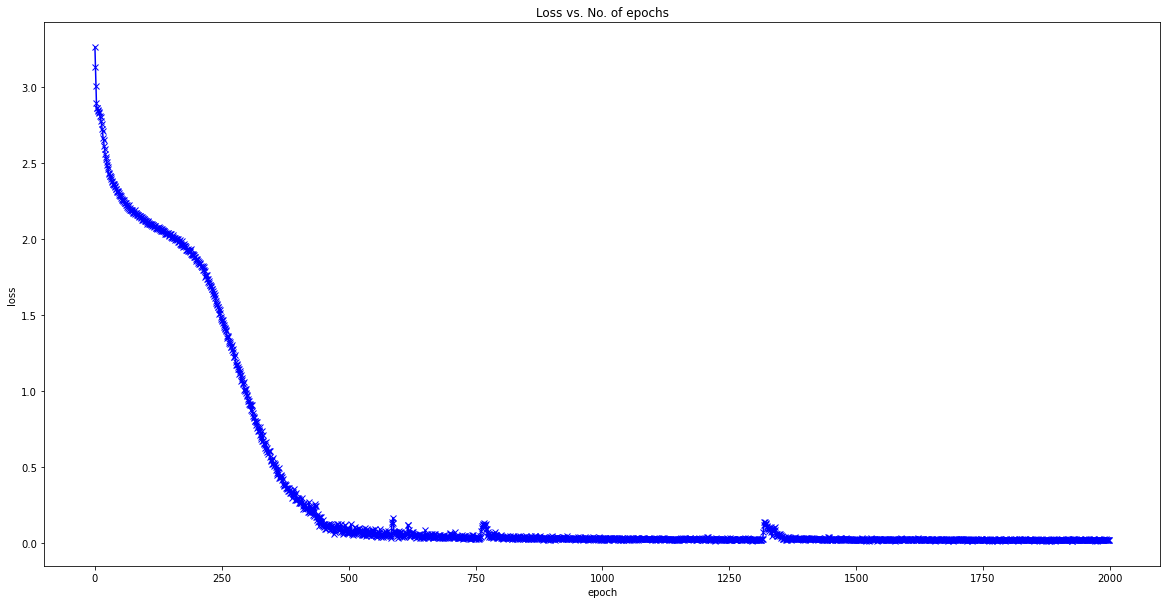

In [33]:
plot_losses(loss_list)

# Use torch.nn.RNN()

In [34]:
rnn_layer = nn.RNN(len(vocab), num_hiddens)
init_state = torch.zeros((1, batch_size, num_hiddens))
print(init_state.shape)
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, init_state)
print(Y.shape)
print(state_new.shape)

torch.Size([1, 32, 512])
torch.Size([35, 32, 512])
torch.Size([1, 32, 512])


In [35]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later), `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to (`num_steps` * `batch_size`, `num_hiddens`). 
        # Its output shape is (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens),device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device))

# Use torch.nn.RNN()

In [36]:
rnn_net = RNNModel(rnn_layer, vocab_size=len(vocab))
rnn_net = rnn_net.to(device)
predict('time traveller', 10, rnn_net, vocab, device)

'time travellerjkkeejeeee'

In [37]:
num_epochs, lr = 2000, 0.5
loss_list = train_rnn(rnn_net, train_iter, vocab, lr, num_epochs, device)

time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch -> 1 			Loss -> tensor(3.0871, device='cuda:0', grad_fn=<DivBackward0>)
time travellere and and and and and and and and and and and and 
Epoch -> 25 			Loss -> tensor(2.3187, device='cuda:0', grad_fn=<DivBackward0>)
time traveller the the the the the the the the the the the the t
Epoch -> 50 			Loss -> tensor(2.1041, device='cuda:0', grad_fn=<DivBackward0>)
time traveller and the the thas ans of the that in thave that ma
Epoch -> 75 			Loss -> tensor(2.0062, device='cuda:0', grad_fn=<DivBackward0>)
time travellere mancenis thithed and har ghes anoul that icale s
Epoch -> 100 			Loss -> tensor(1.9162, device='cuda:0', grad_fn=<DivBackward0>)
time traveller and ar anow youre ion ano stowe this loulhestire 
Epoch -> 125 			Loss -> tensor(1.6112, device='cuda:0', grad_fn=<DivBackward0>)
time traveller asting wio nesther if that ion is four whath le w
Epoch -> 150 			Loss -> tensor(1.1728, device='cuda:0', grad_fn=<DivBa

time traveller with a slight accession ofcheerfulness really thi
Epoch -> 1425 			Loss -> tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>)
time traveller with a slight accession ofcheerfulness really thi
Epoch -> 1450 			Loss -> tensor(0.0226, device='cuda:0', grad_fn=<DivBackward0>)
time traveller for so it will be convenient to speak of himwas e
Epoch -> 1475 			Loss -> tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>)
time traveller for so it will be convenient to speak of himwas e
Epoch -> 1500 			Loss -> tensor(0.0240, device='cuda:0', grad_fn=<DivBackward0>)
time traveller for so it will be convenient to speak of himwas e
Epoch -> 1525 			Loss -> tensor(0.0227, device='cuda:0', grad_fn=<DivBackward0>)
time traveller with a slight accession ofcheerfulness really thi
Epoch -> 1550 			Loss -> tensor(0.0164, device='cuda:0', grad_fn=<DivBackward0>)
time traveller for so it will be convenient to speak of himwas e
Epoch -> 1575 			Loss -> tensor(0.0199, device='cuda:0', gr

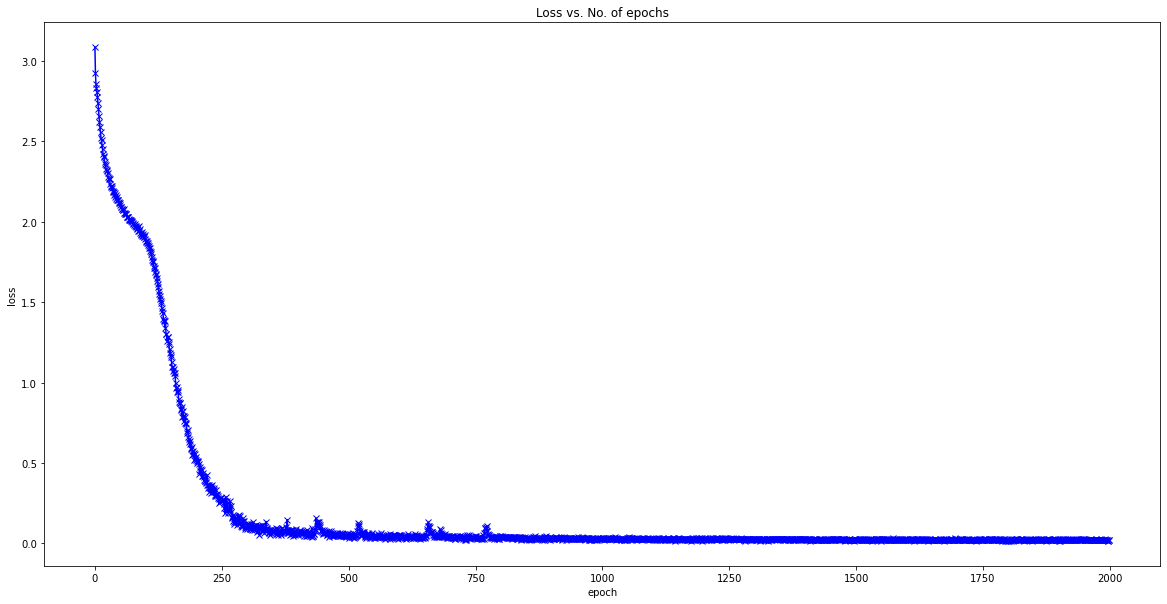

In [38]:
plot_losses(loss_list)